# Scenario discovery

In this part we use the method PRIM to find scenarios, which are likely to be the worst for our actor. Since we have to deal with two locations, we sometimes do the analysis twice.  
The scenario's are ran on the base case, so that is without any policy. The dataset will contain 50.000 scenario's, with the following outcome variables:
- External Costs
- RfR Costs
- Expected Number of Deaths
- Expected Annual Damage



In [117]:
# import the libaries
from ema_workbench import load_results
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from ema_workbench.analysis import prim
import numpy as np
from ema_workbench.util import ema_logging
from ema_workbench.analysis import pairs_plotting, prim
from sklearn.preprocessing import (MinMaxScaler, StandardScaler)
from sklearn.metrics import pairwise_distances

### 1. Explore the scenario runs 

In [39]:
# define filename. The file is saved in the same directory as the notebook.
input_filename = 'results/base_case'

# load the results
results = load_results(input_filename + '.tar.gz')

In [81]:
# split the results into experiments and outcomes
experiments, outcomes = results

# print the shape of the experiments
print('shape =', experiments.shape)

# display the head of the experiments
display(experiments.head())

shape = (50000, 53)


,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model
0,51,124.944949,1.5,0.965480,186.612558,1.5,0.361192,298.085251,1.0,0.690434,...,0,0,0,0,0,0,0,0,No Policy,dikesnet
1,21,221.109051,1.5,0.172842,126.656576,1.5,0.614823,184.312460,1.5,0.323419,...,0,0,0,0,0,0,0,1,No Policy,dikesnet
2,131,207.887019,10.0,0.353144,338.832903,10.0,0.165925,329.104042,10.0,0.940157,...,0,0,0,0,0,0,0,2,No Policy,dikesnet
3,93,315.490331,1.5,0.313171,317.617281,1.5,0.397788,231.794434,1.5,0.210204,...,0,0,0,0,0,0,0,3,No Policy,dikesnet
4,82,293.111014,1.5,0.699879,305.636300,1.0,0.471546,214.687587,10.0,0.327454,...,0,0,0,0,0,0,0,4,No Policy,dikesnet


In [82]:
# Step 1: Identify the indices to drop
experiments_to_drop = [i for i, result in enumerate(outcomes['A.1_Expected Annual Damage']) if result == 0]

print(f"Initial length of experiments: {len(experiments)}")
print(f"Initial length of outcomes['A.1_Expected Annual Damage']: {len(outcomes['A.1_Expected Annual Damage'])}")
print(f"Number of indices to drop: {len(experiments_to_drop)}")

# Step 2: Drop the experiments using the identified indices
experiments = experiments.drop(experiments.index[experiments_to_drop])

print(f"Length of experiments after drop: {len(experiments)}")

# Step 3: Drop the corresponding outcomes
new_outcomes = {}
for key in outcomes:
    new_outcomes[key] = np.delete(outcomes[key], experiments_to_drop)
    print(f"Length of new_outcomes[{key}] after drop: {len(new_outcomes[key])}")

outcomes = new_outcomes

# Verify the lengths are consistent
assert len(experiments) == len(outcomes['A.1_Expected Annual Damage']), "Lengths are inconsistent!"
print("Lengths are consistent")


Initial length of experiments: 50000
Initial length of outcomes['A.1_Expected Annual Damage']: 50000
Number of indices to drop: 8697
Length of experiments after drop: 41303
Length of new_outcomes[A.1_External Costs] after drop: 41303
Length of new_outcomes[A.1_RfR Costs] after drop: 41303
Length of new_outcomes[A.1_Expected Number of Deaths] after drop: 41303
Length of new_outcomes[A.1_Expected Annual Damage] after drop: 41303
Length of new_outcomes[A.2_External Costs] after drop: 41303
Length of new_outcomes[A.2_RfR Costs] after drop: 41303
Length of new_outcomes[A.2_Expected Number of Deaths] after drop: 41303
Length of new_outcomes[A.2_Expected Annual Damage] after drop: 41303
Lengths are consistent


In [84]:
# Our objectives are the following: External Costs, RfR Costs, Expected Number of Deaths, Expected Annual Damage
# Per location, so times 2. 

# Make a dataframe with the outcomes
df_outcomes = pd.DataFrame(outcomes)
df_outcomes

,A.1_External Costs,A.1_RfR Costs,A.1_Expected Number of Deaths,A.1_Expected Annual Damage,A.2_External Costs,A.2_RfR Costs,A.2_Expected Number of Deaths,A.2_Expected Annual Damage
0,0,0,1.515402,2.057940e+09,0,0,0.000000,0.000000e+00
1,0,0,1.466953,2.122853e+09,0,0,0.081071,9.001870e+07
2,0,0,1.536291,2.120436e+09,0,0,0.000000,0.000000e+00
3,0,0,0.032005,4.698537e+07,0,0,0.084541,9.525426e+07
4,0,0,1.538166,1.682361e+09,0,0,0.000000,0.000000e+00
...,...,...,...,...,...,...,...,...
41298,0,0,0.032769,4.572404e+07,0,0,0.033297,3.457147e+07
41299,0,0,0.001158,1.687636e+06,0,0,0.052262,5.817448e+07
41300,0,0,0.000198,3.050305e+05,0,0,0.073482,8.748160e+07
41301,0,0,1.531159,2.075030e+09,0,0,0.000000,0.000000e+00


In [85]:
# So, as can be seen, External and RfR Costs are the same for all locations. Namely, zero. 
df_outcomes.nunique()

A.1_External Costs                   1
A.1_RfR Costs                        1
A.1_Expected Number of Deaths     3276
A.1_Expected Annual Damage       20401
A.2_External Costs                   1
A.2_RfR Costs                        1
A.2_Expected Number of Deaths    22247
A.2_Expected Annual Damage       27191
dtype: int64

To find the worst-case scenarios for which we will optimise policy levers later on, we must first determine for which outcomes of interest these scenarios should be considered worst-case. We consider the following four outcomes:
- A.1_Expected Annual Damage
- A.2_Expected Annual Damage
- A.1_Expected Number of Deaths
- A.2_Expected Number of Deaths

Given the fact that we value each of these outcomes equally, we will add another column to the dataframe for which we will conduct the PRIM analysis. This column will contain the normalised and then aggregated values for the four outcomes mentioned above.

In [86]:
df_outcomes[['A.1_Expected Annual Damage', 'A.1_Expected Number of Deaths', 'A.2_Expected Annual Damage', 'A.2_Expected Number of Deaths']].head(3)


,A.1_Expected Annual Damage,A.1_Expected Number of Deaths,A.2_Expected Annual Damage,A.2_Expected Number of Deaths
0,2.057940e+09,1.515402,0.000000e+00,0.000000
1,2.122853e+09,1.466953,9.001870e+07,0.081071
2,2.120436e+09,1.536291,0.000000e+00,0.000000


In [87]:
scaler = MinMaxScaler()
normalized_ooi = scaler.fit_transform(df_outcomes[['A.1_Expected Annual Damage', 'A.1_Expected Number of Deaths', 
                                                   'A.2_Expected Annual Damage', 'A.2_Expected Number of Deaths']])
composite_ooi = normalized_ooi.sum(axis=1)
df_outcomes['composite_ooi'] = composite_ooi 

In [88]:
df_outcomes

,A.1_External Costs,A.1_RfR Costs,A.1_Expected Number of Deaths,A.1_Expected Annual Damage,A.2_External Costs,A.2_RfR Costs,A.2_Expected Number of Deaths,A.2_Expected Annual Damage,composite_ooi
0,0,0,1.515402,2.057940e+09,0,0,0.000000,0.000000e+00,1.618988
1,0,0,1.466953,2.122853e+09,0,0,0.081071,9.001870e+07,1.805781
2,0,0,1.536291,2.120436e+09,0,0,0.000000,0.000000e+00,1.652114
3,0,0,0.032005,4.698537e+07,0,0,0.084541,9.525426e+07,0.242022
4,0,0,1.538166,1.682361e+09,0,0,0.000000,0.000000e+00,1.514604
...,...,...,...,...,...,...,...,...,...
41298,0,0,0.032769,4.572404e+07,0,0,0.033297,3.457147e+07,0.114004
41299,0,0,0.001158,1.687636e+06,0,0,0.052262,5.817448e+07,0.128341
41300,0,0,0.000198,3.050305e+05,0,0,0.073482,8.748160e+07,0.184179
41301,0,0,1.531159,2.075030e+09,0,0,0.000000,0.000000e+00,1.634460


In [51]:
# The outcomes of interest are all columns in df_outcomes.
outcomes_of_interest = list(df_outcomes.columns)

# Split the outcomes of interest into the different location
outcomes_of_interest_A1 = [i for i in outcomes_of_interest if 'A.1' in i]
outcomes_of_interest_A2 = [i for i in outcomes_of_interest if 'A.2' in i]

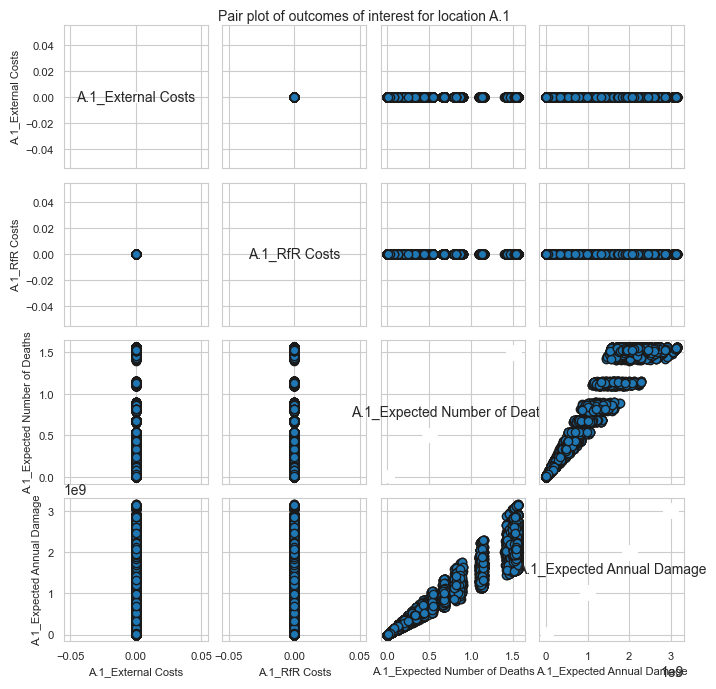

In [96]:
# Create subset of outcomes of interest for location A.1
outcomes_subset = {k:outcomes[k] for k in outcomes_of_interest_A1 if k in outcomes}

# Create a pair plot of the outcomes of interest of location A.1
fig, axes = pairs_plotting.pairs_scatter(experiments, outcomes_subset, group_by="policy", legend=False)
fig.set_size_inches(8, 8)

for ax in axes.values():
    ax.tick_params(axis='both', which='major', labelsize=8)  # Set the font size of the tick labels
    ax.xaxis.label.set_size(8)  # Set the font size of the x-axis labels
    ax.yaxis.label.set_size(8)  # Set the font size of the y-axis labels

fig.suptitle("Pair plot of outcomes of interest for location A.1", fontsize=10, y=0.9)
# plt.savefig('imgages/scenario_discovery_outcomes_A1_pairplot.png')
plt.show()

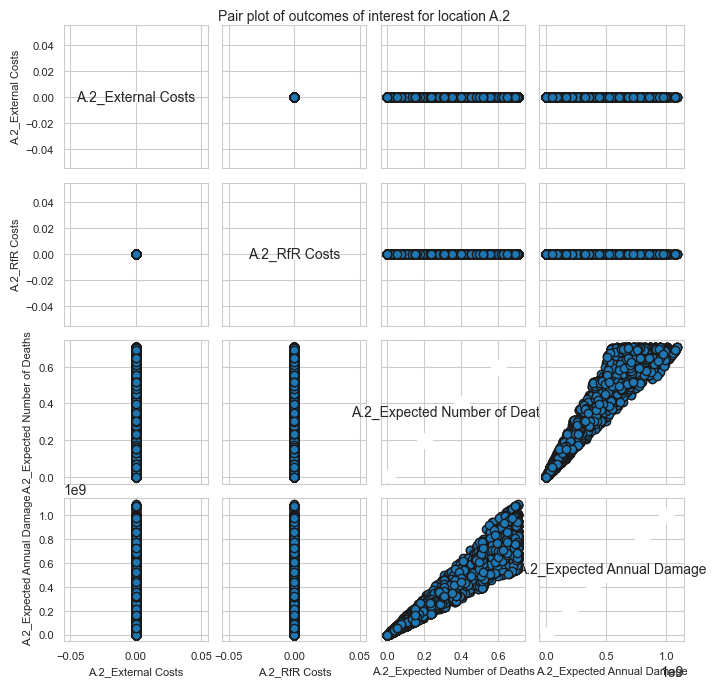

In [97]:
# Create subset of outcomes of interest for location A.2
outcomes_subset = {k:outcomes[k] for k in outcomes_of_interest_A2 if k in outcomes}

# Create a pair plot of the outcomes of interest of location A.1
fig, axes = pairs_plotting.pairs_scatter(experiments, outcomes_subset, group_by="policy", legend=False)
fig.set_size_inches(8, 8)

for ax in axes.values():
    ax.tick_params(axis='both', which='major', labelsize=8)  # Set the font size of the tick labels
    ax.xaxis.label.set_size(8)  # Set the font size of the x-axis labels
    ax.yaxis.label.set_size(8)  # Set the font size of the y-axis labels

fig.suptitle("Pair plot of outcomes of interest for location A.2", fontsize=10, y=0.9)
# plt.savefig('imgages/scenario_discovery_outcomes_A2_pairplot.png')
plt.show()

So, conclusions which can be made for both locations are:

- External costs are always 0.
- RfR costs are always 0.
- Both is logical, since in the base case, without any policy, there will not be any External costs (Expected Evacuation Costs and Dike Investment Costs) or RfR costs. 
- Expected number of Deaths and Expected Annual Damage are decently strong correlated. Which actually makes sense.
- Difference is mainly the gradation of numbers. For location A2 the range of figures of expected annual damage and expected number of deaths are significantly lower than for location A1.

### Experiments

In [98]:
experiments_sliced = experiments.iloc[:,:19]
experiments_sliced

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,A.4_Bmax,A.4_Brate,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1,discount rate 2
1,21,221.109051,1.5,0.172842,126.656576,1.5,0.614823,184.312460,1.5,0.323419,274.533484,1.0,0.860717,270.590253,1.0,0.058684,1.5,4.5,4.5
2,131,207.887019,10.0,0.353144,338.832903,10.0,0.165925,329.104042,10.0,0.940157,152.659419,1.0,0.867790,72.352163,10.0,0.029257,2.5,3.5,2.5
3,93,315.490331,1.5,0.313171,317.617281,1.5,0.397788,231.794434,1.5,0.210204,34.673513,1.5,0.081300,118.053353,1.0,0.285650,2.5,4.5,2.5
4,82,293.111014,1.5,0.699879,305.636300,1.0,0.471546,214.687587,10.0,0.327454,288.279890,1.0,0.527409,167.064316,1.0,0.648632,3.5,2.5,1.5
6,42,287.573331,1.5,0.172422,264.840452,10.0,0.580016,331.882711,1.5,0.922784,51.405211,1.5,0.462624,174.116421,1.5,0.232368,4.5,3.5,4.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,62,321.616643,1.5,0.724065,71.881936,10.0,0.690810,348.476106,1.5,0.564494,73.173805,1.5,0.792240,250.531944,10.0,0.788202,4.5,1.5,2.5
49996,36,314.197104,1.5,0.790554,78.448640,1.0,0.535387,190.467088,1.5,0.478701,88.545218,1.0,0.321918,215.959007,1.0,0.324620,1.5,2.5,3.5
49997,30,113.594422,1.0,0.840008,175.576458,1.0,0.509296,299.492845,1.0,0.710544,235.318213,1.0,0.870422,307.847717,10.0,0.862621,2.5,2.5,1.5
49998,55,334.081152,1.0,0.318638,298.865589,1.5,0.614740,144.360129,10.0,0.886877,67.236182,1.5,0.814070,190.160572,1.0,0.609990,1.5,4.5,4.5


Hieronder is algoritme om de threshold te bepalen. Hij plot meerdere graphs en op een gegeven moment zie je wanneer hij het niet meer doet.  Als je telt, zie je dus dat 0.75 de laatse plot is waar nog meerdere nr. of destricted dimensions zijn.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Threshold 0.50:
Threshold 0.55:
Threshold 0.60:
Threshold 0.65:
Threshold 0.70:
Threshold 0.75:
Threshold 0.80:
Threshold 0.85:
Threshold 0.90:


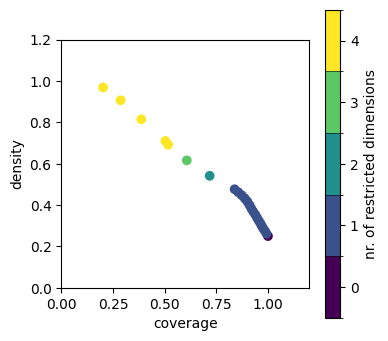

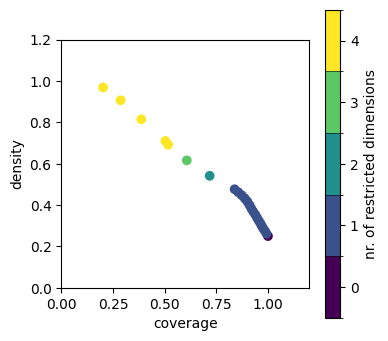

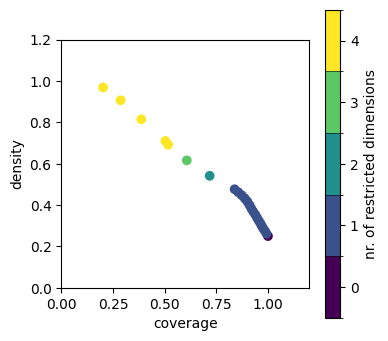

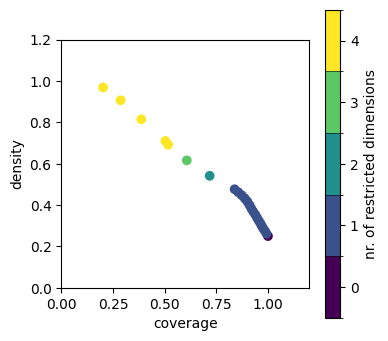

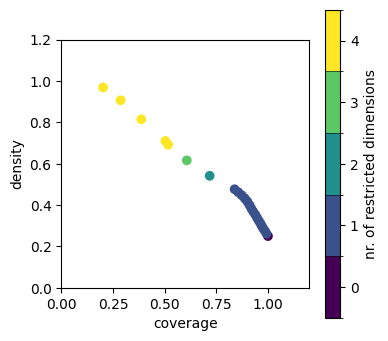

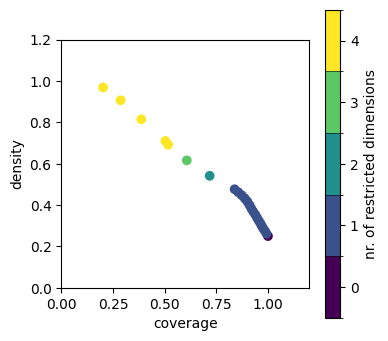

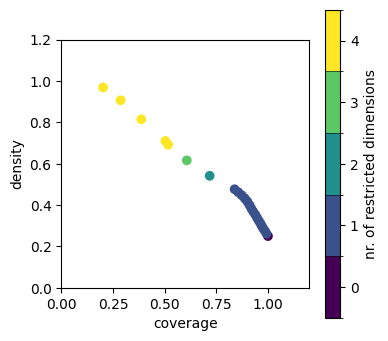

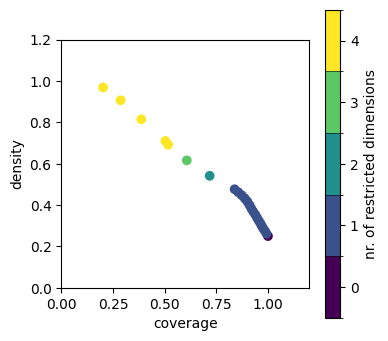

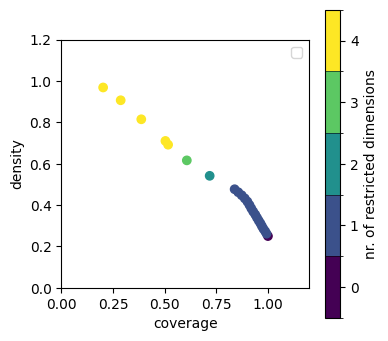

In [100]:
## To find the threshold

percentile_composite_ooi = np.percentile(df_outcomes["composite_ooi"], 75)

# Bool the values if they are larger than the threshold
selval = pd.DataFrame()
selval = df_outcomes["composite_ooi"] > percentile_composite_ooi

# List to store results
boxes = []
thresholds = np.arange(0.5, 0.95, 0.05)

for threshold in thresholds:
    prim_alg = prim.Prim(experiments_sliced, selval, threshold=threshold, peel_alpha=0.05)
    box = prim_alg.find_box()
    boxes.append((threshold, box))

plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams["figure.figsize"] = (4, 4)

# Plot trade-offs for different thresholds
for threshold, box in boxes:
    print(f'Threshold {threshold:.2f}:')
    box.show_tradeoff()

plt.legend()
plt.show()


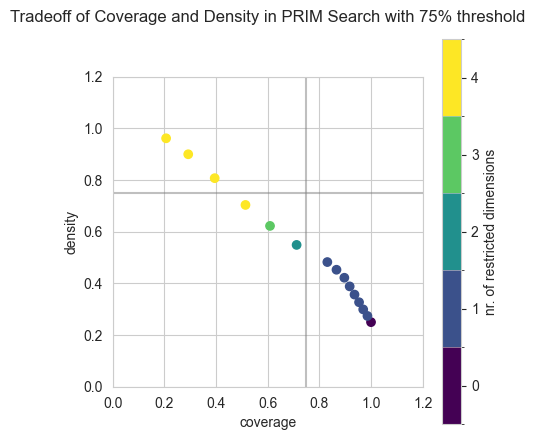

In [58]:
# Execute prim algorithm
# We select the value for peel_alpha by trial and error such that we get all the dimensions as output 
# as well as a threshold above 0.65
prim_alg = prim.Prim(experiments_sliced, selval, threshold=0.9, peel_alpha=0.1)
box1 = prim_alg.find_box()

plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams["figure.figsize"] = (5,5)

sns.set_style('whitegrid')

# Show trade off plot
box1.show_tradeoff()
plt.hlines(y=[0.75], xmin=0, xmax=1.2, colors='grey', alpha=0.5)
plt.vlines(x=[0.75], ymin=0, ymax=1.2, colors='grey', alpha=0.5)
plt.title('Tradeoff of Coverage and Density in PRIM Search with 75% threshold', y=1.15)

#plt.savefig("PRIM_tradeoff_scenarios")
plt.show()

In [101]:
box1.peeling_trajectory

,coverage,density,id,k,mass,mean,n,res_dim
0,1.000000,0.249982,0,10325,1.000000,0.249982,41303,0
1,0.986150,0.273916,1,10182,0.899983,0.273916,37172,1
2,0.969782,0.299307,2,10013,0.809965,0.299307,33454,1
3,0.953705,0.327056,3,9847,0.728954,0.327056,30108,1
4,0.936077,0.356682,4,9665,0.656054,0.356682,27097,1
5,0.917385,0.388404,5,9472,0.590441,0.388404,24387,1
6,0.896755,0.421861,6,9259,0.531390,0.421861,21948,1
7,0.866344,0.452843,7,8945,0.478246,0.452843,19753,1
8,0.830896,0.482590,8,8579,0.430405,0.482590,17777,1
9,0.711961,0.548951,9,7351,0.324214,0.548951,13391,2


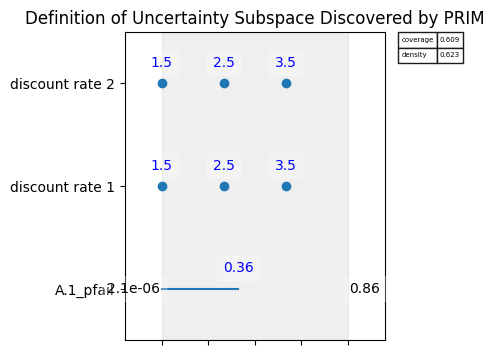

In [102]:
box1.select(10)
box1.inspect(style="graph", ticklabel_formatter='{}', boxlim_formatter='{:.2g}')
plt.title('Definition of Uncertainty Subspace Discovered by PRIM')
# plt.savefig('img/scenario_discovery__prim_boundary.png')
plt.show()

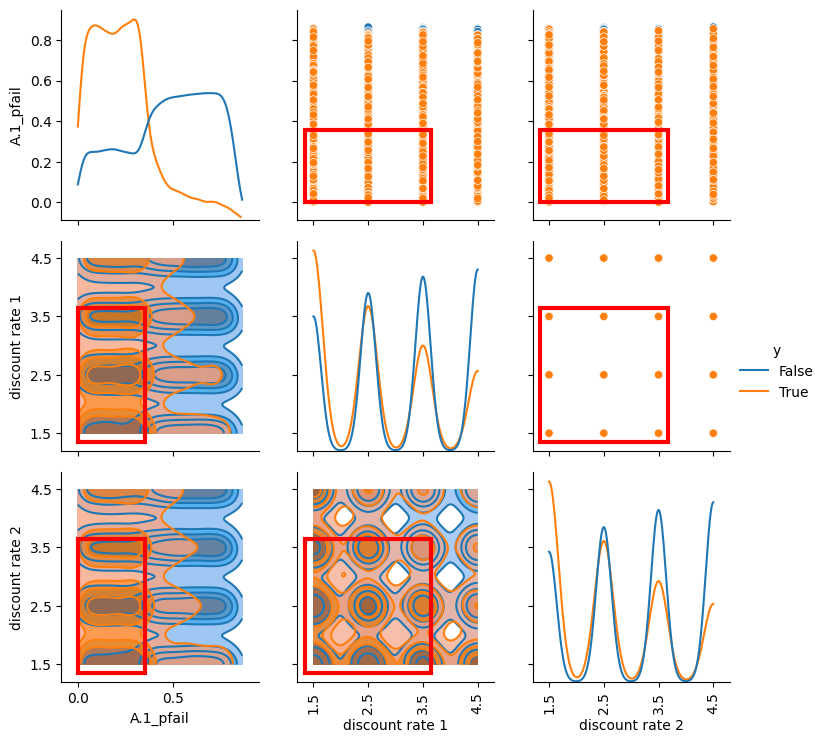

In [103]:
box1.show_pairs_scatter()
# show_pairs_scatter doesn't give enough vertical space to show suptitle
# plt.suptitle('Classified Scenario Runs by Key Uncertainty Values'
#              'with PRIM Box Superimposed', y=0.97)
# plt.savefig('img/scenario_discovery__prim_pairs_scatter.png')
plt.show()

In [104]:
limits = box1.box_lims[10]
limits

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,A.4_Bmax,A.4_Brate,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1,discount rate 2
0,0,30.004597,"{1.5, 10.0, 1.0}",0.000002,30.000705,"{1.5, 10.0, 1.0}",6.540993e-07,30.005824,"{1.5, 10.0, 1.0}",0.000054,30.005383,"{1.0, 10.0, 1.5}",0.000021,30.003400,"{1.0, 10.0, 1.5}",0.000011,"{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5}","{1.5, 2.5, 3.5}"
1,132,349.999846,"{1.5, 10.0, 1.0}",0.355531,349.999139,"{1.5, 10.0, 1.0}",9.999961e-01,349.995529,"{1.5, 10.0, 1.0}",0.999970,349.995618,"{1.0, 10.0, 1.5}",0.999946,349.994093,"{1.0, 10.0, 1.5}",0.999998,"{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5}","{1.5, 2.5, 3.5}"


In [106]:
combined_df = experiments.copy()
combined_df = combined_df.reset_index(drop=True)
combined_df = combined_df.merge(df_outcomes[['composite_ooi']], how = 'left', left_index = True, right_index = True)
combined_df['In box limits'] = True

In [107]:

# Create a mask initialized to True
mask = np.ones(len(combined_df), dtype=bool)

# Iterate over the constraints and update the mask
for unc in limits:
    if isinstance(limits.loc[0, unc], set):
        mask &= combined_df[unc].isin(limits.loc[0, unc])
    else:
        mask &= (combined_df[unc] >= limits.loc[0, unc]) & (combined_df[unc] <= limits.loc[1, unc])

# Update the 'In box limits' column based on the mask
combined_df['In box limits'] = mask

In [108]:
# Use new column to filter the rows, then drop this column
combined_df = combined_df[combined_df['In box limits']]
combined_df = combined_df.drop(['In box limits'], axis=1)
print(f'{combined_df.shape[0]} fall within the PRIM box limits')

10101 fall within the PRIM box limits


In [111]:
# Sort the dataframe by the composite outcome of interest from worst to best
combined_df_sorted = combined_df.sort_values(by='composite_ooi', ascending=False)


In [136]:
experiments_sliced_columns = list(experiments_sliced.columns)
experiments_sliced_columns.append('composite_ooi')
selected_scenarios = combined_df[experiments_sliced_columns]

In [115]:
combined_df_sorted

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model,composite_ooi
4717,104,40.525349,10.0,0.161001,187.789168,1.5,0.010373,205.979011,1.0,0.958783,...,0,0,0,0,0,0,5666,No Policy,dikesnet,3.851439
30583,112,45.942740,10.0,0.048710,140.411132,1.0,0.024664,82.938927,1.5,0.397429,...,0,0,0,0,0,0,37006,No Policy,dikesnet,3.842797
9000,124,40.037075,1.5,0.142803,341.756695,1.5,0.036182,77.097873,1.5,0.527626,...,0,0,0,0,0,0,10872,No Policy,dikesnet,3.806214
19463,8,71.302063,1.0,0.046825,345.456662,1.0,0.011393,30.957752,1.5,0.700170,...,0,0,0,0,0,0,23514,No Policy,dikesnet,3.743779
376,123,43.660903,10.0,0.199587,181.602356,1.0,0.058039,222.809776,1.5,0.212183,...,0,0,0,0,0,0,456,No Policy,dikesnet,3.716082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1024,9,251.130655,10.0,0.351589,265.852622,1.5,0.691111,233.272468,1.0,0.781174,...,0,0,0,0,0,0,1235,No Policy,dikesnet,1.183542
15145,116,156.430088,10.0,0.350967,143.971990,1.0,0.844108,345.839395,1.5,0.965133,...,0,0,0,0,0,0,18263,No Policy,dikesnet,1.175790
37681,88,152.810901,1.5,0.352143,101.440530,10.0,0.894286,340.303813,1.0,0.634012,...,0,0,0,0,0,0,45633,No Policy,dikesnet,1.141099
10611,51,239.958286,1.5,0.353762,290.956814,10.0,0.698580,323.661590,10.0,0.172793,...,0,0,0,0,0,0,12786,No Policy,dikesnet,1.136038


In [116]:
selected_scenarios

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,A.4_Bmax,A.4_Brate,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1,discount rate 2,composite_ooi
1,131,207.887019,10.0,0.353144,338.832903,10.0,0.165925,329.104042,10.0,0.940157,152.659419,1.0,0.867790,72.352163,10.0,0.029257,2.5,3.5,2.5,1.805781
10,98,40.518658,10.0,0.048493,215.015110,10.0,0.251750,43.043888,10.0,0.950841,178.101227,1.0,0.518300,71.103245,10.0,0.311620,1.5,1.5,3.5,2.260276
20,12,167.406190,1.5,0.174979,49.163026,1.0,0.271578,132.586343,10.0,0.963526,54.478333,1.5,0.254924,108.744231,1.5,0.088771,3.5,1.5,3.5,1.760958
23,125,291.894321,1.5,0.347685,105.079724,1.0,0.363267,137.921457,1.0,0.907215,279.933260,10.0,0.635755,251.046869,1.0,0.840339,2.5,1.5,3.5,1.668958
24,80,218.417706,1.0,0.198631,93.769663,10.0,0.507612,73.498724,10.0,0.034389,97.715779,10.0,0.126002,328.301520,1.0,0.450534,2.5,3.5,3.5,1.620348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41286,85,98.654095,1.5,0.250192,309.389771,1.5,0.587045,172.614260,1.5,0.773476,272.567996,1.5,0.467034,286.772726,1.5,0.760244,2.5,2.5,1.5,1.797747
41291,95,128.170391,1.5,0.106112,227.702535,1.5,0.595248,182.067542,10.0,0.006082,349.173811,10.0,0.716067,348.709777,1.0,0.943736,4.5,2.5,3.5,1.583694
41292,5,183.911294,10.0,0.200902,121.726054,1.5,0.123799,252.289825,10.0,0.502917,184.640638,1.0,0.930993,326.141996,1.0,0.326025,1.5,2.5,3.5,1.856764
41295,124,320.794278,1.5,0.144287,251.945157,10.0,0.557395,35.526966,10.0,0.290034,332.606699,10.0,0.030084,97.867982,1.0,0.887276,4.5,2.5,3.5,1.597175


In [119]:
# Randomly sample approximately 100 scenarios to reduce the computational burden
sampled_df = selected_scenarios.sample(n=100, random_state=42)

# Normalize the data to ensure fair distance calculations
scaler = StandardScaler()
sampled_df_scaled = scaler.fit_transform(sampled_df)

# Calculate pairwise distances between all sampled scenarios
distance_matrix = pairwise_distances(sampled_df_scaled, metric='euclidean')

# Function to select the most diverse scenarios
def select_diverse_scenarios(distance_matrix, n_select=4):
    # Start with the first scenario
    selected_indices = [0]
    while len(selected_indices) < n_select:
        # Calculate the sum of distances from the already selected scenarios
        dist_sum = np.sum(distance_matrix[selected_indices], axis=0)
        # Select the scenario that maximizes the minimum distance to the already selected scenarios
        next_index = np.argmax(dist_sum)
        selected_indices.append(next_index)
    return selected_indices

# Get indices of the 4 most diverse scenarios
diverse_indices = select_diverse_scenarios(distance_matrix, n_select=4)

# Retrieve the 4 most diverse scenarios from the sampled dataframe
diverse_scenarios = sampled_df.iloc[diverse_indices]

# Print the diverse scenarios
diverse_scenarios


,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,A.4_Bmax,A.4_Brate,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1,discount rate 2,composite_ooi
12275,26,210.807918,1.5,0.092027,172.374261,1.5,0.517100,254.006564,1.0,0.915031,165.440227,10.0,0.235617,183.021862,10.0,0.342190,2.5,1.5,3.5,1.755893
39833,101,123.723596,10.0,0.087285,315.055206,1.0,0.019649,34.954835,10.0,0.305029,145.432329,1.0,0.862907,209.075297,1.5,0.009042,1.5,3.5,3.5,3.194440
35280,119,84.948477,10.0,0.294570,305.283047,10.0,0.702650,220.064913,1.0,0.326005,49.619647,1.5,0.009365,306.976860,10.0,0.426481,4.5,3.5,1.5,1.702246
20422,20,323.962775,1.5,0.190418,328.161863,10.0,0.014162,302.061696,10.0,0.051706,289.845385,1.5,0.059208,83.701692,1.0,0.692434,1.5,1.5,3.5,2.902360


In [128]:
# Select the four most diverse scenarios and the scenario with the highest composite outcome of interest as scenarios to be further analyzed
selected_indices = diverse_scenarios.index.tolist()
selected_indices.append(combined_df_sorted.index[0])
print(selected_indices)


[12275, 39833, 35280, 20422, 4717]


In [137]:
selected_scenarios.drop('composite_ooi', axis=1, inplace=True)
selected_scenarios.loc[selected_indices].to_csv('results/selected_scenarios.csv')

/var/folders/mz/j0q1_7_x2f59p13bv_c81xhc0000gn/T/ipykernel_23662/1422912885.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_scenarios.drop('composite_ooi', axis=1, inplace=True)
